In [1]:
import findspark
findspark.init()
findspark.find()
import pyspark

import os
import functools as reduce
from pyspark.context import SparkContext
from pyspark.sql import DataFrame, SQLContext, SparkSession, Window
from pyspark.sql.functions import *
from pyspark.sql.types import *

# Importing other MLlib Libraries
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.classification import LogisticRegression
from pyspark.ml.evaluation import BinaryClassificationEvaluator

conf = pyspark.SparkConf().setAppName('Credit Card Fraud Detection').setMaster('local')
sc = pyspark.SparkContext(conf = conf)
spark = SparkSession(sc)
sqlContext = SQLContext(sc)

In [2]:
# Importing other relevant libraries
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
spark

In [4]:
# Dataset Link: spark-practice-de.s3.amazonaws.com/creditcard_fraud.rar

In [5]:
# Reading the dataset
df = spark.read.csv(r"creditcard_fraud.csv", header=True, inferSchema=True)

In [6]:
df.printSchema()

root
 |-- Time: integer (nullable = true)
 |-- V1: double (nullable = true)
 |-- V2: double (nullable = true)
 |-- V3: double (nullable = true)
 |-- V4: double (nullable = true)
 |-- V5: double (nullable = true)
 |-- V6: double (nullable = true)
 |-- V7: double (nullable = true)
 |-- V8: double (nullable = true)
 |-- V9: double (nullable = true)
 |-- V10: double (nullable = true)
 |-- V11: double (nullable = true)
 |-- V12: double (nullable = true)
 |-- V13: double (nullable = true)
 |-- V14: double (nullable = true)
 |-- V15: double (nullable = true)
 |-- V16: double (nullable = true)
 |-- V17: double (nullable = true)
 |-- V18: double (nullable = true)
 |-- V19: double (nullable = true)
 |-- V20: double (nullable = true)
 |-- V21: double (nullable = true)
 |-- V22: double (nullable = true)
 |-- V23: double (nullable = true)
 |-- V24: double (nullable = true)
 |-- V25: double (nullable = true)
 |-- V26: double (nullable = true)
 |-- V27: double (nullable = true)
 |-- V28: double (null

In [7]:
# Count of Fraudulent and Non-Fraudulent Transactions
df.groupby("Class").count().show()

+-----+-----+
|Class|count|
+-----+-----+
|    1|  223|
|    0|99776|
+-----+-----+



In [8]:
df.columns

['Time',
 'V1',
 'V2',
 'V3',
 'V4',
 'V5',
 'V6',
 'V7',
 'V8',
 'V9',
 'V10',
 'V11',
 'V12',
 'V13',
 'V14',
 'V15',
 'V16',
 'V17',
 'V18',
 'V19',
 'V20',
 'V21',
 'V22',
 'V23',
 'V24',
 'V25',
 'V26',
 'V27',
 'V28',
 'Amount',
 'Class']

In [9]:
# Getting distinct counts of the columns in the dataset
df.agg(*(countDistinct(col(c)).alias(c) for c in df.columns)).show()

+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+------+-----+
| Time|   V1|   V2|   V3|   V4|   V5|   V6|   V7|   V8|   V9|  V10|  V11|  V12|  V13|  V14|  V15|  V16|  V17|  V18|  V19|  V20|  V21|  V22|  V23|  V24|  V25|  V26|  V27|  V28|Amount|Class|
+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+------+-----+
|45546|97499|97499|97499|97499|97499|97499|97499|97499|97499|97499|97499|97499|97499|97499|97499|97499|97499|97499|97499|97499|97499|97499|97499|97499|97499|97499|97499|97499| 19768|    2|
+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+------+-----+



In [10]:
assembler = VectorAssembler(inputCols=[col for col in df.columns if col != "Class"],
                           outputCol="features")

In [11]:
dataset = assembler.transform(df)

In [12]:
dataset.show(5)

+----+------------------+-------------------+----------------+------------------+-------------------+-------------------+-------------------+------------------+------------------+-------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+-------------------+------------------+-------------------+--------------------+-------------------+------------------+------------------+------------------+------------------+--------------------+-------------------+------+-----+--------------------+
|Time|                V1|                 V2|              V3|                V4|                 V5|                 V6|                 V7|                V8|                V9|                V10|               V11|               V12|               V13|               V14|               V15|               V16|               V17|                V18|               V19|                V20|                 V21|    

In [13]:
# Since, we only need label and features column for model building. Hence, selecting only relevant columns
model_data = dataset.select(["features", "Class"])
model_data = model_data.withColumnRenamed("Class", "label")
model_data.show()

+--------------------+-----+
|            features|label|
+--------------------+-----+
|[0.0,-1.359807133...|    0|
|[0.0,1.1918571113...|    0|
|[1.0,-1.358354061...|    0|
|[1.0,-0.966271711...|    0|
|[2.0,-1.158233093...|    0|
|[2.0,-0.425965884...|    0|
|[4.0,1.2296576345...|    0|
|[7.0,-0.644269442...|    0|
|[7.0,-0.894286082...|    0|
|[9.0,-0.338261752...|    0|
|[10.0,1.449043781...|    0|
|[10.0,0.384978215...|    0|
|[10.0,1.249998742...|    0|
|[11.0,1.069373587...|    0|
|[12.0,-2.79185476...|    0|
|[12.0,-0.75241704...|    0|
|[12.0,1.103215435...|    0|
|[13.0,-0.43690507...|    0|
|[14.0,-5.40125766...|    0|
|[15.0,1.492935976...|    0|
+--------------------+-----+
only showing top 20 rows



Training Split at 0.5 %


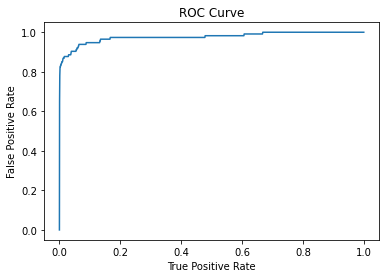

Training set areaUnderCurve: 0.9762570621023045


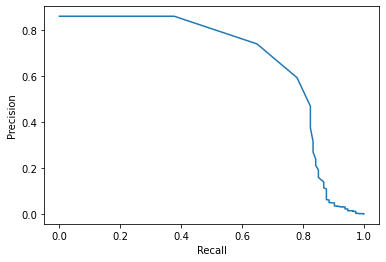

Test Area under ROC 0.9707444685000827
Training Split at 0.55 %


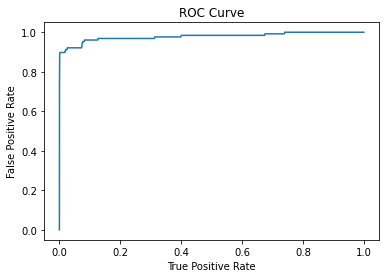

Training set areaUnderCurve: 0.9785680644657294


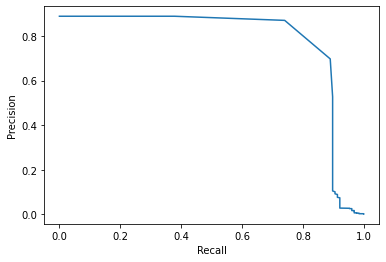

Test Area under ROC 0.9767806886616605
Training Split at 0.6 %


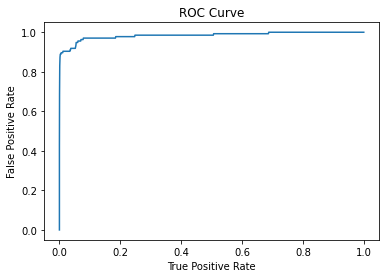

Training set areaUnderCurve: 0.9838877774072895


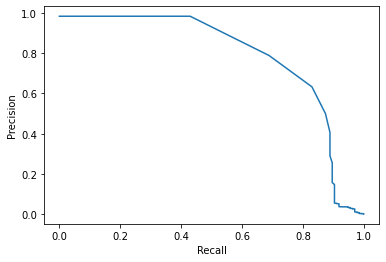

Test Area under ROC 0.9459803235135578
Training Split at 0.65 %


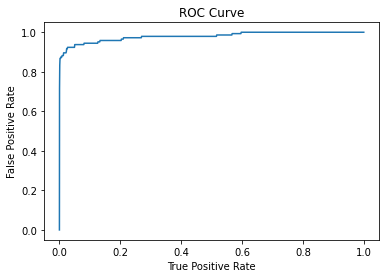

Training set areaUnderCurve: 0.9793807316061582


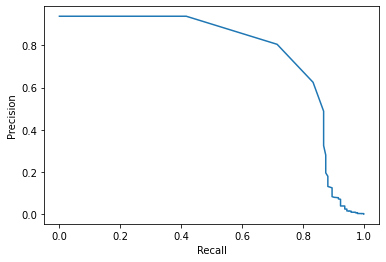

Test Area under ROC 0.9588704497777072
Training Split at 0.7 %


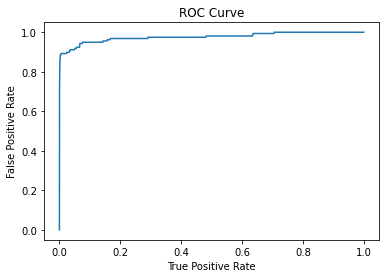

Training set areaUnderCurve: 0.976318477153297


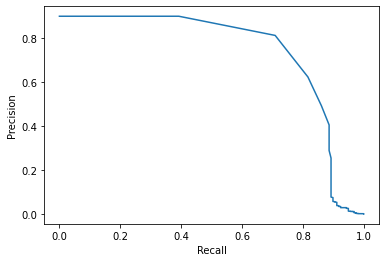

Test Area under ROC 0.9592376500179169
Training Split at 0.75 %


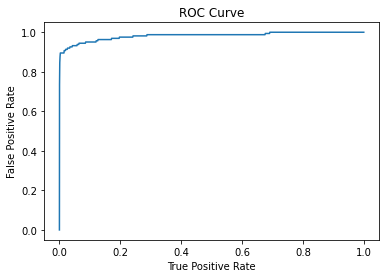

Training set areaUnderCurve: 0.9819968963625967


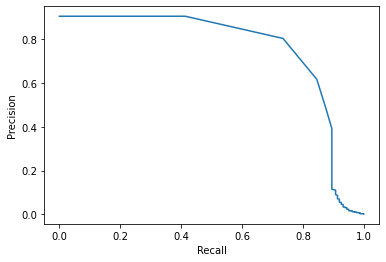

Test Area under ROC 0.9414795041024548
Training Split at 0.8 %


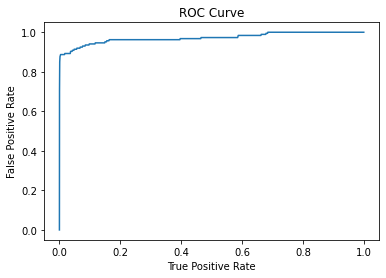

Training set areaUnderCurve: 0.9717483214621386


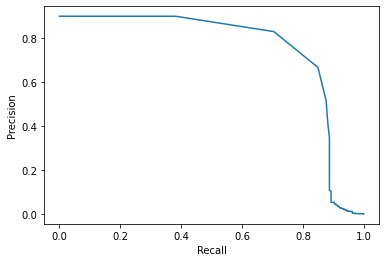

Test Area under ROC 0.9876902043811282
Training Split at 0.85 %


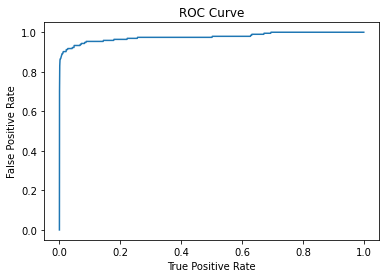

Training set areaUnderCurve: 0.9765549015552721


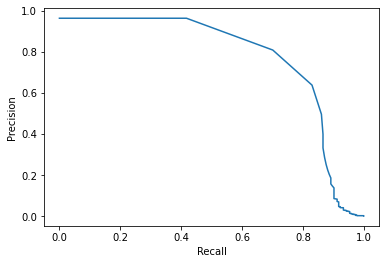

Test Area under ROC 0.9367329538214193
Training Split at 0.9 %


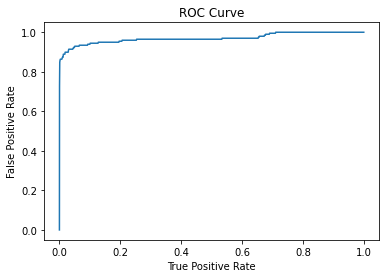

Training set areaUnderCurve: 0.9696950901835477


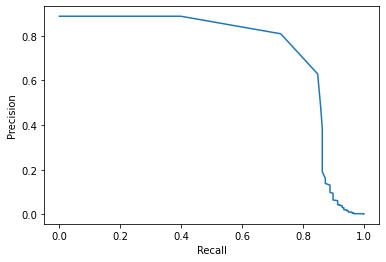

Test Area under ROC 0.9860079942605314
Training Split at 0.95 %


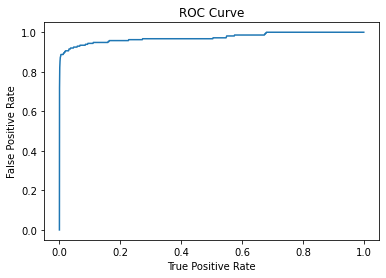

Training set areaUnderCurve: 0.9731360508663274


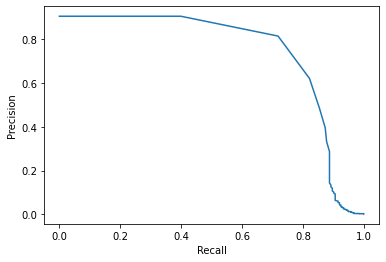

Test Area under ROC 0.9881976395279056


In [14]:
# Model Building
p_train = [0.50, 0.55, 0.60, 0.65, 0.70, 0.75, 0.80, 0.85, 0.90, 0.95]
train_ROC = []
test_ROC = []

for p in p_train:
    
    print("Training Split at", str(p),"%")
    # Splitting the dataset in train and test
    train, test = model_data.randomSplit([p, 1-p])
    lr = LogisticRegression(featuresCol="features", labelCol="label")
    model = lr.fit(train)

    # Plot on Train dataset
    trainingSummary = model.summary
    roc = trainingSummary.roc.toPandas()
    plt.plot(roc["FPR"], roc["TPR"])
    plt.ylabel("False Positive Rate")
    plt.xlabel("True Positive Rate")
    plt.title("ROC Curve")
    plt.show()

    print("Training set areaUnderCurve: " + str(trainingSummary.areaUnderROC))
    train_ROC.append(trainingSummary.areaUnderROC)
    
    # Precision Recall Curve
    pr = trainingSummary.pr.toPandas()
    plt.plot(pr["recall"], pr["precision"])
    plt.ylabel("Precision")
    plt.xlabel("Recall")
    plt.show()

    # Evaluating on test dataset
    summary = model.evaluate(test)
    summary.accuracy

    output = model.transform(test)

    evaluator = BinaryClassificationEvaluator()
    print("Test Area under ROC", evaluator.evaluate(output))
    
    test_ROC.append(evaluator.evaluate(output))

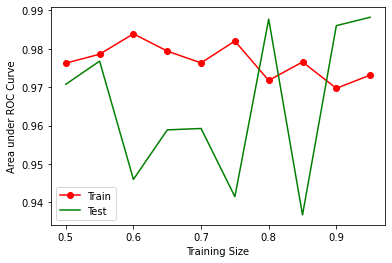

In [15]:
# Plotting
plt.plot(p_train, train_ROC, "ro-", label = "Train")
plt.plot(p_train, test_ROC, "g", label = "Test")
plt.xlabel("Training Size")
plt.ylabel("Area under ROC Curve")
plt.legend()
plt.show()

In [16]:
print("The best Accuracy is received: "+str(sorted(test_ROC)[-1]))

The best Accuracy is received: 0.9881976395279056
